In [1]:
import os, sys
import sys
import numpy as np
from scipy import signal
from  matplotlib import pyplot as plt
import librosa
import IPython.display as ipd
import pandas as pd
sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c6

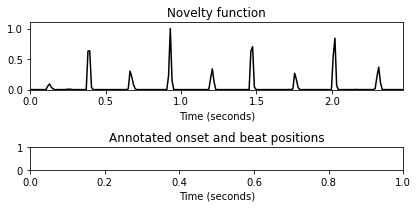

In [2]:
fn_wav = 'FMP_C6_F01_Queen.wav'

x, Fs = librosa.load(fn_wav)
x_duration = len(x)/Fs
nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs)

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(6, 3))
libfmp.b.plot_signal(nov, Fs_nov, ax=ax[0], color='k', title='Novelty function');
# libfmp.b.plot_annotation_line(ann, ax=ax[1], label_keys=label_keys,
                    # time_min=0, time_max=x_duration)
ax[1].set_title('Annotated onset and beat positions')
ax[1].set_xlabel('Time (seconds)')

plt.tight_layout()

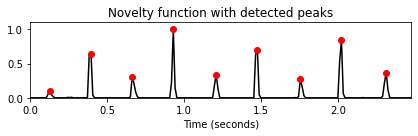

/var/folders/wn/fhcj6_9d2qb5d0pw_xw20ky80000gn/T/ipykernel_3254/3003695592.py:11: FutureWarning: Pass times=[0.12770975 0.39473923 0.66176871 0.92879819 1.20743764 1.47446712
 1.75310658 2.02013605 2.31038549] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  x_peaks = librosa.clicks(peaks_sec, sr=Fs, click_freq=1000, length=len(x))


In [5]:
peaks, properties = signal.find_peaks(nov, prominence=0.02)
T_coef = np.arange(nov.shape[0]) / Fs_nov
peaks_sec = T_coef[peaks]
fig, ax, line = libfmp.b.plot_signal(nov, Fs_nov, color='k', 
                    title='Novelty function with detected peaks')
# libfmp.b.plot_annotation_line(ann, ax=ax, label_keys=label_keys, 
                    # nontime_axis=True, time_min=0, time_max=x_duration)
plt.plot(peaks_sec, nov[peaks], 'ro')
plt.show()

x_peaks = librosa.clicks(peaks_sec, sr=Fs, click_freq=1000, length=len(x))
ipd.display(ipd.Audio(x + x_peaks, rate=Fs))

---

/var/folders/wn/fhcj6_9d2qb5d0pw_xw20ky80000gn/T/ipykernel_3254/3360806176.py:2: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  x, Fs = librosa.load(fn_wav, Fs)


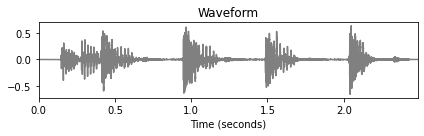

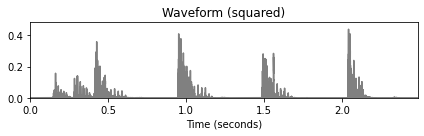

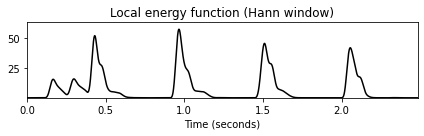

In [6]:
Fs = 22050
x, Fs = librosa.load(fn_wav, Fs) 
x_duration = len(x)/Fs

N = 2048
w = signal.hann(N)

#Calculate local energy
x_square = x**2
energy_local = np.convolve(x_square, w**2, 'same')

libfmp.b.plot_signal(x, Fs, title='Waveform')
libfmp.b.plot_signal(x_square, Fs, title='Waveform (squared)')
fig, ax, line = libfmp.b.plot_signal(energy_local, Fs, color='k', 
                    title='Local energy function (Hann window)')
# libfmp.b.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
#                     nontime_axis=True, time_min=0, time_max=x_duration);
plt.tight_layout()

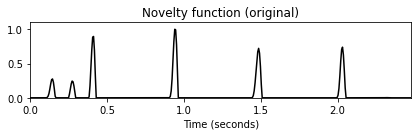

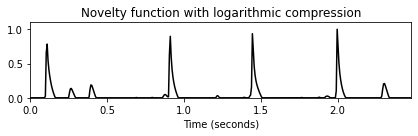

In [8]:
def compute_novelty_energy(x, Fs=1, N=2048, H=128, gamma=10.0, norm=True):
    """Compute energy-based novelty function

    Notebook: C6/C6S1_NoveltyEnergy.ipynb

    Args:
        x (np.ndarray): Signal
        Fs (scalar): Sampling rate (Default value = 1)
        N (int): Window size (Default value = 2048)
        H (int): Hop size (Default value = 128)
        gamma (float): Parameter for logarithmic compression (Default value = 10.0)
        norm (bool): Apply max norm (if norm==True) (Default value = True)

    Returns:
        novelty_energy (np.ndarray): Energy-based novelty function
        Fs_feature (scalar): Feature rate
    """
    # x_power = x**2
    w = signal.hann(N)
    Fs_feature = Fs / H
    energy_local = np.convolve(x**2, w**2, 'same')
    energy_local = energy_local[::H]
    if gamma is not None:
        energy_local = np.log(1 + gamma * energy_local)
    energy_local_diff = np.diff(energy_local)
    energy_local_diff = np.concatenate((energy_local_diff, np.array([0])))
    novelty_energy = np.copy(energy_local_diff)
    novelty_energy[energy_local_diff < 0] = 0
    if norm:
        max_value = max(novelty_energy)
        if max_value > 0:
            novelty_energy = novelty_energy / max_value
    return novelty_energy, Fs_feature

N = 2048
H = 128
nov_1, Fs_nov = compute_novelty_energy(x, Fs=Fs, N=N, H=H, gamma=None)
nov_2, Fs_nov = compute_novelty_energy(x, Fs=Fs, N=N, H=H, gamma=1000)

fig, ax, line = libfmp.b.plot_signal(nov_1, Fs=Fs_nov, color='k', 
                    title='Novelty function (original)')
# libfmp.b.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                    # nontime_axis=True, time_min=0, time_max=x_duration);
fig, ax, line = libfmp.b.plot_signal(nov_2, Fs=Fs_nov, color='k',
                    title='Novelty function with logarithmic compression')
# libfmp.b.plot_annotation_line(ann, ax=ax, label_keys=label_keys,
                    # nontime_axis=True, time_min=0, time_max=x_duration);